In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from collections import OrderedDict
from scipy import stats
from scipy.signal import find_peaks

Loading data and preliminary skimming

In [112]:
data_051 = pd.read_excel('dataset/051.xlsx')
max_feed = data_051.loc[data_051['label'] == 1]['timestamp'].max()
min_feed = data_051.loc[data_051['label'] == 1]['timestamp'].min()
max_feed = datetime.datetime.fromtimestamp(max_feed/1000.0)
min_feed = datetime.datetime.fromtimestamp(min_feed/1000.0)
feed_time = max_feed-min_feed
#0
print('mulai makan: ' +str(min_feed))
print('akhir makan: ' + str(max_feed))
print('lama makan: ' + str(max_feed-min_feed))
max_afk = data_051.loc[data_051['label'] == 0]['timestamp'].max()
min_afk = data_051.loc[data_051['label'] == 0]['timestamp'].min()
max_afk = datetime.datetime.fromtimestamp(max_afk/1000.0)
min_afk = datetime.datetime.fromtimestamp(min_afk/1000.0)
afk_time = max_afk-min_afk
#1
print('mulai afk: ' +str(min_afk))
print('akhir afk: ' + str(max_afk))


mulai makan: 2022-07-06 14:41:54.320000
akhir makan: 2022-07-06 14:43:38.280000
lama makan: 0:01:43.960000
mulai afk: 2022-07-06 14:43:38.320000
akhir afk: 2022-07-06 14:45:22.280000


In [113]:
data_102 = pd.read_excel('dataset/102.xlsx')
max_feed = data_102.loc[data_102['label'] == 1]['timestamp'].max()
min_feed = data_102.loc[data_102['label'] == 1]['timestamp'].min()
max_feed = datetime.datetime.fromtimestamp(max_feed/1000.0)
min_feed = datetime.datetime.fromtimestamp(min_feed/1000.0)
feed_time = max_feed-min_feed
#0
print('mulai makan: ' +str(min_feed))
print('akhir makan: ' + str(max_feed))
print('lama makan: ' + str(max_feed-min_feed))
max_afk = data_102.loc[data_102['label'] == 0]['timestamp'].max()
min_afk = data_102.loc[data_102['label'] == 0]['timestamp'].min()
max_afk = datetime.datetime.fromtimestamp(max_afk/1000.0)
min_afk = datetime.datetime.fromtimestamp(min_afk/1000.0)
afk_time = max_afk-min_afk
#1
print('mulai afk: ' +str(min_afk))
print('akhir afk: ' + str(max_afk))


mulai makan: 2022-07-06 14:53:24.880000
akhir makan: 2022-07-06 14:54:39.720000
lama makan: 0:01:14.840000
mulai afk: 2022-07-06 14:54:39.760000
akhir afk: 2022-07-06 14:55:54.600000


After I realized that all of the data are connected as one continous event, I concatted the all of the sheet data

In [114]:
data_051 = pd.read_excel('dataset/051.xlsx')
data_051 = data_051.assign(id=51)
data_101 = pd.read_excel('dataset/101.xlsx')
data_101 = data_101.assign(id=101)
data_102 = pd.read_excel('dataset/102.xlsx')
data_102 = data_102.assign(id=102)
data_103 = pd.read_excel('dataset/103.xlsx')
data_102 = data_102.assign(id=103)
data_161 = pd.read_excel('dataset/161.xlsx')
data_161 = data_161.assign(id=161)
data_162 = pd.read_excel('dataset/162.xlsx')
data_162 = data_162.assign(id=162)
data_163 = pd.read_excel('dataset/163.xlsx')
data_163 = data_163.assign(id=163)
data_list = [data_051, data_101, data_102, data_103, data_161, data_162, data_163]
df_all = pd.concat(data_list)

As the timestamp data was still in unix, I converted it into datetime

In [115]:
df_all = df_all.sort_values('timestamp')
df_all['timestamp_raw'] = df_all['timestamp']
df_all['timestamp'] = [datetime.datetime.fromtimestamp(col/1000.0) for col in df_all['timestamp']]
df_all

,timestamp,x,y,z,label,id,timestamp_raw
0,2022-07-06 14:40:02.000,-4,231,37,1,163.0,1657093202000
1,2022-07-06 14:40:02.040,7,232,33,1,163.0,1657093202040
2,2022-07-06 14:40:02.080,10,234,37,1,163.0,1657093202080
3,2022-07-06 14:40:02.120,4,242,43,1,163.0,1657093202120
4,2022-07-06 14:40:02.160,0,260,46,1,163.0,1657093202160
...,...,...,...,...,...,...,...
4571,2022-07-06 14:58:57.480,-1,243,42,0,101.0,1657094337480
4572,2022-07-06 14:58:57.520,-1,244,41,0,101.0,1657094337520
4573,2022-07-06 14:58:57.560,0,244,43,0,101.0,1657094337560
4574,2022-07-06 14:58:57.600,-2,246,44,0,101.0,1657094337600


I made a function to get the feeding times and afk times for the fish for each data

In [116]:
def get_avg_activity_time(data):
    max_feed = data.loc[data['label'] == 1]['timestamp'].max()
    min_feed = data.loc[data['label'] == 1]['timestamp'].min()
    max_feed = datetime.datetime.fromtimestamp(max_feed/1000.0)
    min_feed = datetime.datetime.fromtimestamp(min_feed/1000.0)
    feed_time = max_feed-min_feed
    #0
    print('mulai makan: ' +str(min_feed))
    print('akhir makan: ' + str(max_feed))
    print('lama makan: ' + str(max_feed-min_feed))
    max_afk = data.loc[data['label'] == 0]['timestamp'].max()
    min_afk = data.loc[data['label'] == 0]['timestamp'].min()
    max_afk = datetime.datetime.fromtimestamp(max_afk/1000.0)
    min_afk = datetime.datetime.fromtimestamp(min_afk/1000.0)
    afk_time = max_afk-min_afk
    #1
    print('mulai afk: ' +str(min_afk))
    print('akhir afk: ' + str(max_afk))
    return feed_time,afk_time, min_feed

After running the function on all of the data, I appended it to a list containing all the feed times and afk times, and also added the data into a dictionary containing all the important information regarding the time

In [117]:
all_dict = dict()
feed_time_ls = list()
afk_time_ls = list()
counter=0
for i in data_list:
    feed_time, afk_time,min_feed = get_avg_activity_time(i)
    feed_time_ls.append(feed_time)
    afk_time_ls.append(afk_time)
    all_dict[counter] = {
        'feed_time_raw': feed_time,
        'feed_time': str(feed_time),
        'afk_time': str(afk_time),
        'min_feed': str(min_feed)
    }
    counter+=1
print(feed_time_ls)
print(OrderedDict(sorted(all_dict.items(), key=lambda x: x[1]['min_feed'], reverse=False)))

mulai makan: 2022-07-06 14:41:54.320000
akhir makan: 2022-07-06 14:43:38.280000
lama makan: 0:01:43.960000
mulai afk: 2022-07-06 14:43:38.320000
akhir afk: 2022-07-06 14:45:22.280000
mulai makan: 2022-07-06 14:55:54.640000
akhir makan: 2022-07-06 14:57:26.120000
lama makan: 0:01:31.480000
mulai afk: 2022-07-06 14:57:26.160000
akhir afk: 2022-07-06 14:58:57.640000
mulai makan: 2022-07-06 14:53:24.880000
akhir makan: 2022-07-06 14:54:39.720000
lama makan: 0:01:14.840000
mulai afk: 2022-07-06 14:54:39.760000
akhir afk: 2022-07-06 14:55:54.600000
mulai makan: 2022-07-06 14:49:44.400000
akhir makan: 2022-07-06 14:51:34.600000
lama makan: 0:01:50.200000
mulai afk: 2022-07-06 14:51:34.640000
akhir afk: 2022-07-06 14:53:24.840000
mulai makan: 2022-07-06 14:47:18.800000
akhir makan: 2022-07-06 14:48:31.560000
lama makan: 0:01:12.760000
mulai afk: 2022-07-06 14:48:31.600000
akhir afk: 2022-07-06 14:49:44.360000
mulai makan: 2022-07-06 14:45:22.320000
akhir makan: 2022-07-06 14:46:20.520000
lama 

Ordered the dictionary based on chronological order, which in this case is the start of the feeding time, because all of the data begins with feeding first and then afk

In [118]:
all_dict = OrderedDict(sorted(all_dict.items(), key=lambda x: x[1]['min_feed'], reverse=False))

And then after I got the data, I plotted it to get context on the feeding patterns to determine the schedule of feeding

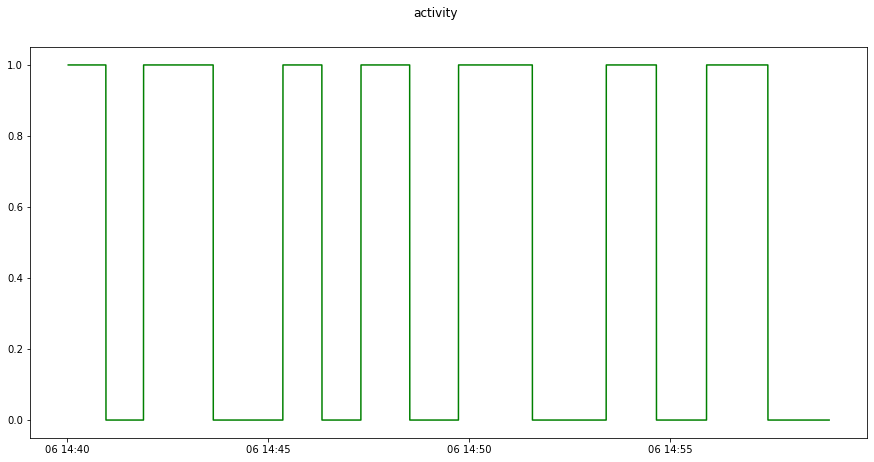

In [119]:
plot, axax = plt.subplots(nrows=1, figsize=(15, 7), sharex=True)
axax.plot(df_all['timestamp'], df_all['label'], 'g')
plt.subplots_adjust(hspace=0.2)
plot.suptitle('activity')
plt.subplots_adjust(top=0.90)
plt.show()

Added the portioning based on previous information that the total amount of feed is 5kgs, and distributed it based on duration of feeding

In [120]:
for i in all_dict:
    all_dict[i]['portion'] = all_dict[i]['feed_time_raw']/sum(feed_time_ls, datetime.timedelta(0))*5

In [121]:
all_dict

OrderedDict([(6,
              {'feed_time_raw': datetime.timedelta(seconds=56, microseconds=120000),
               'feed_time': '0:00:56.120000',
               'afk_time': '0:00:56.120000',
               'min_feed': '2022-07-06 14:40:02',
               'portion': 0.49439706815138484}),
             (0,
              {'feed_time_raw': datetime.timedelta(seconds=103, microseconds=960000),
               'feed_time': '0:01:43.960000',
               'afk_time': '0:01:43.960000',
               'min_feed': '2022-07-06 14:41:54.320000',
               'portion': 0.9158503065755162}),
             (5,
              {'feed_time_raw': datetime.timedelta(seconds=58, microseconds=200000),
               'feed_time': '0:00:58.200000',
               'afk_time': '0:00:58.200000',
               'min_feed': '2022-07-06 14:45:22.320000',
               'portion': 0.5127211219959124}),
             (4,
              {'feed_time_raw': datetime.timedelta(seconds=72, microseconds=760000),
         

Set frequency and labels

In [122]:
Fs = 25
activities = df_all['label'].value_counts().index
activities

Int64Index([0, 1], dtype='int64')

Plot the x, y, z accelerations

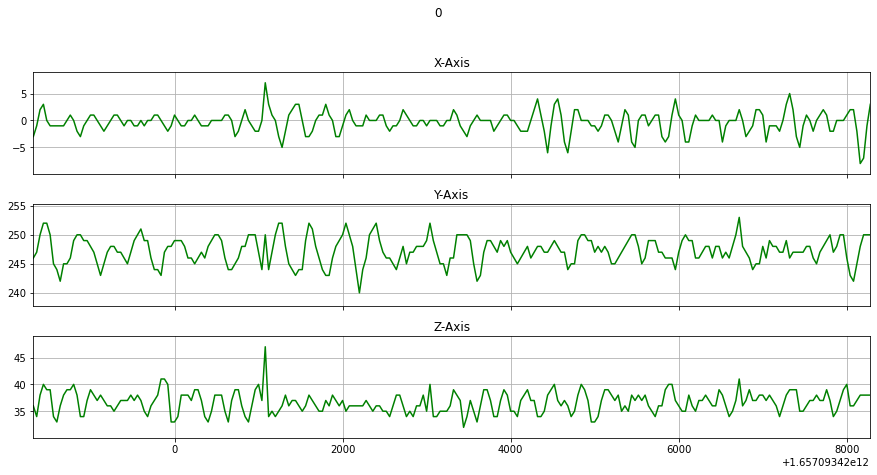

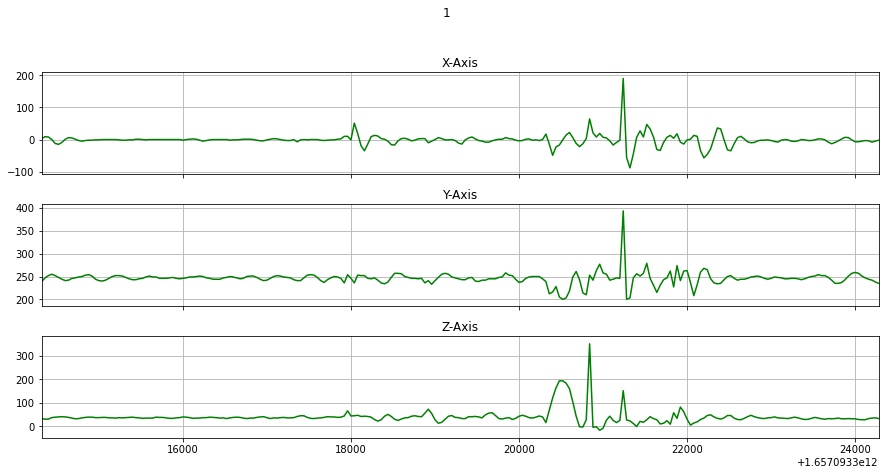

In [123]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
    plot_axis(ax0, data['timestamp'], data['x'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.3)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.85)
    plt.show()

def plot_activity_fft(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
    plot_axis(ax0, data['timestamp'], np.fft.fft(data['x']), 'X-Axis')
    plot_axis(ax1, data['timestamp'], np.fft.fft(data['y']), 'Y-Axis')
    plot_axis(ax2, data['timestamp'], np.fft.fft(data['x']), 'Z-Axis')
    plt.subplots_adjust(hspace=0.3)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.85)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(True)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in activities:
    data_for_plot = data_051[(data_051['label'] == activity)][:Fs*10]
    plot_activity(activity, data_for_plot)

Plot FFT on data

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/transforms.py:2802: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/transforms.py:2802: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.8/site-

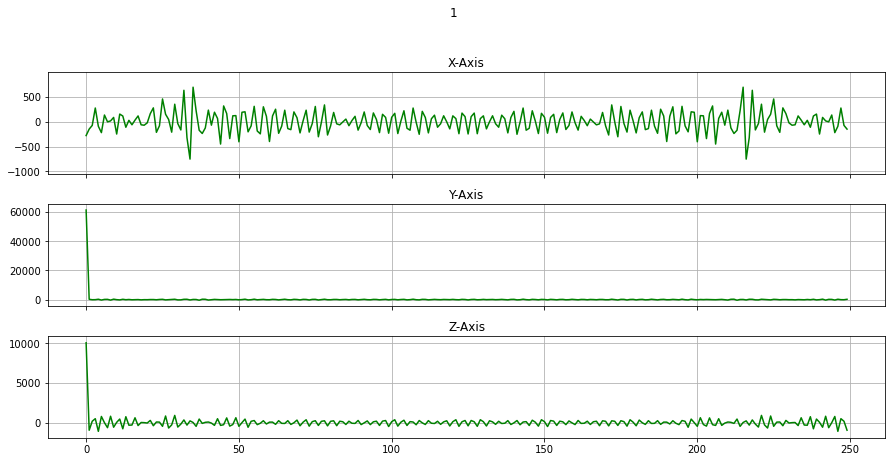

In [124]:
def plot_axis1(ax, y, title):
    ax.plot( y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(True)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.grid(True)

temp = data_051[(data_051['label'] == 1)][:Fs*10]
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
plot_axis1(ax0,  np.fft.fft(temp['x']), 'X-Axis')
plot_axis1(ax1,  np.fft.fft(temp['y']), 'Y-Axis')
plot_axis1(ax2,  np.fft.fft(temp['z']), 'Z-Axis')
plt.subplots_adjust(hspace=0.3)
fig.suptitle(1)
plt.subplots_adjust(top=0.85)
plt.show()





/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/transforms.py:2802: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/transforms.py:2802: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.8/site-

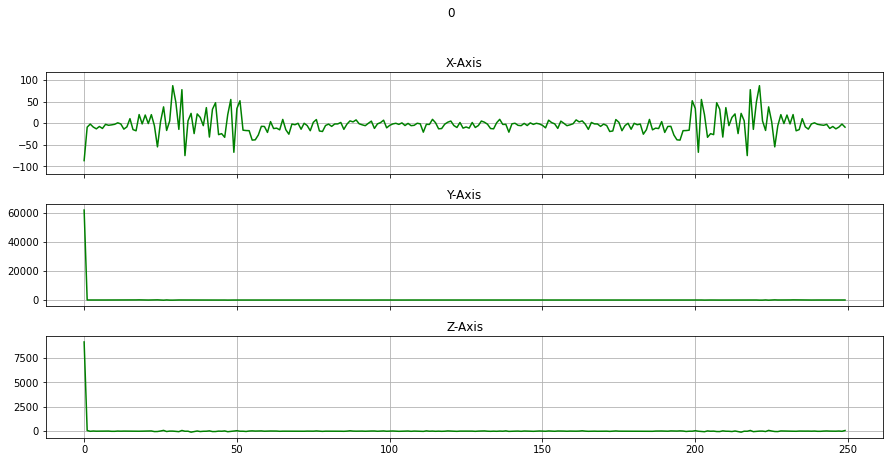

In [125]:
temp = data_051[(data_051['label'] == 0)][:Fs*10]
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
plot_axis1(ax0,  np.fft.fft(temp['x']), 'X-Axis')
plot_axis1(ax1,  np.fft.fft(temp['y']), 'Y-Axis')
plot_axis1(ax2,  np.fft.fft(temp['z']), 'Z-Axis')
plt.subplots_adjust(hspace=0.3)
fig.suptitle(0)
plt.subplots_adjust(top=0.85)
plt.show()


In [126]:
df_train = df_all[df_all['id'] <= 161]
df_test = df_all[df_all['id']> 161]

Drop id and timestamps

In [127]:

df_train = df_train.drop(['id','timestamp','timestamp_raw'], axis=1)
df_test = df_test.drop(['id','timestamp','timestamp_raw'], axis=1)

In [128]:
df_train

,x,y,z,label
0,3,239,34,1
1,9,247,30,1
2,8,252,31,1
3,0,255,37,1
4,-12,252,39,1
...,...,...,...,...
4571,-1,243,42,0
4572,-1,244,41,0
4573,0,244,43,0
4574,-2,246,44,0


Window the data with a window size of 250, and a step_size of 50% of that, which is 125

In [129]:
def create_dataset(data):
    x_list = []
    y_list = []
    z_list = []
    labels = []

    window_size = 250
    step_size = 125

    for i in range(0, data.shape[0] - window_size, step_size):
        xs = data['x'].values[i: i + 250]
        ys = data['y'].values[i: i + 250]
        zs = data['z'].values[i: i + 250]
        label = stats.mode(data['label'][i: i + 250])[0][0]

        x_list.append(xs)
        y_list.append(ys)
        z_list.append(zs)
        labels.append(label)
        
    X = pd.DataFrame()

    # mean
    X['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
    X['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
    X['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

    # std dev
    X['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
    X['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
    X['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

    # min
    X['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
    X['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
    X['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

    # max
    X['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
    X['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
    X['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

    # median
    X['x_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
    X['y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))
    X['z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

    # median abs dev 
    X['x_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    X['y_mad'] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    X['z_mad'] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

    # interquartile range
    X['x_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    X['y_IQR'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    X['z_IQR'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

    # skewness
    X['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
    X['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
    X['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))

    # kurtosis
    X['x_kurtosis'] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x))
    X['y_kurtosis'] = pd.Series(y_list).apply(lambda x: stats.kurtosis(x))
    X['z_kurtosis'] = pd.Series(z_list).apply(lambda x: stats.kurtosis(x))

    # energy
    X['x_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/250)
    X['y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/250)
    X['z_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2/250))

    # avg resultant
    X['avg_result_accl'] = [i.mean() for i in ((pd.Series(x_list)**2 + pd.Series(y_list)**2 + pd.Series(z_list)**2)**0.5)]

    # signal magnitude area
    X['sma'] =    pd.Series(x_list).apply(lambda x: np.sum(abs(x)/250)) + pd.Series(y_list).apply(lambda x: np.sum(abs(x)/250)) \
                    + pd.Series(z_list).apply(lambda x: np.sum(abs(x)/250))
    
    
    # converting the signals from time domain to frequency domain using FFT
    x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:251])
    y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:251])
    z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:251])

    # Statistical Features on raw x, y and z in frequency domain
    # FFT mean
    X['x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
    X['y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
    X['z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())

    # FFT std dev
    X['x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
    X['y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
    X['z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

    # FFT avg absolute diff
    X['x_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    X['y_aad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    X['z_aad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

    # FFT min
    X['x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
    X['y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
    X['z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())

    # FFT max
    X['x_max_fft'] = pd.Series(x_list_fft).apply(lambda x: x.max())
    X['y_max_fft'] = pd.Series(y_list_fft).apply(lambda x: x.max())
    X['z_max_fft'] = pd.Series(z_list_fft).apply(lambda x: x.max())

    # FFT median
    X['x_median_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(x))
    X['y_median_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(x))
    X['z_median_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(x))

    # FFT median abs dev 
    X['x_mad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    X['y_mad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    X['z_mad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))

    # FFT Interquartile range
    X['x_IQR_fft'] = pd.Series(x_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    X['y_IQR_fft'] = pd.Series(y_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    X['z_IQR_fft'] = pd.Series(z_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

    # FFT skewness
    X['x_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x))
    X['y_skewness_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.skew(x))
    X['z_skewness_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.skew(x))

    # FFT kurtosis
    X['x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x))
    X['y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.kurtosis(x))
    X['z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.kurtosis(x))

    # FFT energy
    X['x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/250)
    X['y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/250)
    X['z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/250))

    # FFT avg resultant
    X['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft)**2 + pd.Series(y_list_fft)**2 + pd.Series(z_list_fft)**2)**0.5)]

    # FFT Signal magnitude area
    X['sma_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(abs(x)/250)) + pd.Series(y_list_fft).apply(lambda x: np.sum(abs(x)/250)) \
                        + pd.Series(z_list_fft).apply(lambda x: np.sum(abs(x)/250))

    return X, np.array(labels)
        

Get statistical measures

In [130]:
X, Y_train = create_dataset(df_train)
X_test, Y_test = create_dataset(df_test)

In [131]:
X.shape[0]

136

In [132]:
X.columns

Index(['x_mean', 'y_mean', 'z_mean', 'x_std', 'y_std', 'z_std', 'x_min',
       'y_min', 'z_min', 'x_max', 'y_max', 'z_max', 'x_median', 'y_median',
       'z_median', 'x_mad', 'y_mad', 'z_mad', 'x_IQR', 'y_IQR', 'z_IQR',
       'x_skewness', 'y_skewness', 'z_skewness', 'x_kurtosis', 'y_kurtosis',
       'z_kurtosis', 'x_energy', 'y_energy', 'z_energy', 'avg_result_accl',
       'sma', 'x_mean_fft', 'y_mean_fft', 'z_mean_fft', 'x_std_fft',
       'y_std_fft', 'z_std_fft', 'x_aad_fft', 'y_aad_fft', 'z_aad_fft',
       'x_min_fft', 'y_min_fft', 'z_min_fft', 'x_max_fft', 'y_max_fft',
       'z_max_fft', 'x_median_fft', 'y_median_fft', 'z_median_fft',
       'x_mad_fft', 'y_mad_fft', 'z_mad_fft', 'x_IQR_fft', 'y_IQR_fft',
       'z_IQR_fft', 'x_skewness_fft', 'y_skewness_fft', 'z_skewness_fft',
       'x_kurtosis_fft', 'y_kurtosis_fft', 'z_kurtosis_fft', 'x_energy_fft',
       'y_energy_fft', 'z_energy_fft', 'avg_result_accl_fft', 'sma_fft'],
      dtype='object')

In [133]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# standardization
scaler = StandardScaler()
scaler.fit(X)
X_data_lr = scaler.transform(X)
X_test_data_lr = scaler.transform(X_test)
# logistic regression model
lr = LogisticRegression(random_state = 22)
lr.fit(X_data_lr, Y_train)
y_pred = lr.predict(X_test_data_lr)
print("Accuracy:", accuracy_score(Y_test, y_pred))
print("\n -------------Classification Report-------------\n")
print(classification_report(Y_test, y_pred))

Accuracy: 0.8863636363636364

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       1.00      0.76      0.86        21
           1       0.82      1.00      0.90        23

    accuracy                           0.89        44
   macro avg       0.91      0.88      0.88        44
weighted avg       0.91      0.89      0.88        44



In [134]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# standardization
scaler = StandardScaler()
scaler.fit(X)
X_data_lr = scaler.transform(X)
X_test_data_lr = scaler.transform(X_test)
# logistic regression model
lr = LogisticRegression(random_state = 21)
lr.fit(X_data_lr, Y_train)
y_pred = lr.predict(X_test_data_lr)
print("Accuracy:", accuracy_score(Y_test, y_pred))
print("\n -------------Classification Report-------------\n")
print(classification_report(Y_test, y_pred))

Accuracy: 0.8863636363636364

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       1.00      0.76      0.86        21
           1       0.82      1.00      0.90        23

    accuracy                           0.89        44
   macro avg       0.91      0.88      0.88        44
weighted avg       0.91      0.89      0.88        44

